# **Practical session on Transfer Learning**
This Pratical session proposes to study several techniques for improving challenging context, in which few data and resources are available.

# Introduction

**Context :**

Assume we are in a context where few "gold" labeled data are available for training, say 

$$\mathcal{X}_{\text{train}} = \{(x_n,y_n)\}_{n\leq N_{\text{train}}}$$

where $N_{\text{train}}$ is small. 

A large test set $\mathcal{X}_{\text{test}}$ as well as a large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

**Instructions to follow :** 

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question :

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset!)

In your final report, please *keep the logs of each training procedure* you used. We will only run this jupyter if we have some doubts on your implementation. 

The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.

You can use https://colab.research.google.com/ to run your experiments.

## Training set creation
__Question 1 (1 points) :__ Propose a dataloader to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set.

Additional information :  

*   CIFAR10 dataset : https://en.wikipedia.org/wiki/CIFAR-10
*   You can directly use the dataloader framework from Pytorch.
*   Alternatively you can modify the file : https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py

In [2]:
import torchvision.transforms as transforms
from collections import defaultdict
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
import torchvision
import torch as th
import numpy as np
import copy

In [3]:
def reset_seed(seed=42):
    np.random.seed(seed)
    th.manual_seed(seed)
    th.cuda.manual_seed(seed)
    th.backends.cudnn.deterministic = True
    th.backends.cudnn.benchmark = False

reset_seed()

In [7]:
results = defaultdict(dict)

In [9]:
def plot_results(filter=""):
    fig, ax = plt.subplots(1, 2, figsize=(10, 6))

    
    ax[0].set_title("Train accuracy")
    ax[1].set_title("Test accuracy")

    for test, result in results.items():
        
        if filter and (filter not in test) :
            continue
        
        if not result.values():
            continue
        
        y_0 = max(result["accu"])
        y_1 = result["test_accu"].cpu().item()
        x   = test.replace(filter, "")
        
        ax[0].plot(x, y_0, linestyle='', marker='o', label=str(result["n_epochs"])) 

        ax[0].annotate(f'{y_0:.4g}',
                    (x, y_0),       
                    textcoords="offset points", 
                    xytext=(0,-30),            
                    ha='center',
                    rotation=60)   
         
        ax[1].plot(x, y_1, linestyle='', marker='o', label=str(result["n_epochs"])) 
        ax[1].annotate(f'{y_1:.4g}',
                    (x, y_1),       
                    textcoords="offset points", 
                    xytext=(0,-30),            
                    ha='center',
                    rotation=60)   

    for a in ax:
        a.grid(True)
        a.tick_params(axis='x', rotation=90)
        a.set_ylim(0, 100)
    
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(title="Epochs", loc='lower right')
    ax[1].legend(title="Epochs")

In [10]:
def run_train_test(target,
                   model, 
                   epochs, 
                   optimizer, 
                   criterion, 
                   train_loader, 
                   device):


    reset_seed()
    
    results[target]["n_epochs"] = epochs
    results[target]["accu"] = train(model, 
                                    epochs, 
                                    optimizer, 
                                    criterion, 
                                    train_loader, 
                                    device)

    results[target]["test_accu"] = test(model, criterion, test_loader, device)

In [7]:
batch_size = 10

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root ="\content", train=True, download=True , transform=transform)
train_loader  = th.utils.data.DataLoader(th.utils.data.Subset(trainset, list(np.arange(100))), 
                                         batch_size=batch_size, 
                                         shuffle=True)

testset = torchvision.datasets.CIFAR10(root ="\content", train=False , download=True, transform=transform)
test_loader = th.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


* This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. 

* The remaining samples correspond to $\mathcal{X}$. 

* The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2 (0.5 points):__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

The training procedure is difficult because, given that the training dataset is extremely small, it is very likely that overfitting will happen. The second point is that we selected arbitrarly on the first 100 images of the dataset, which can lead to the data being imbalanced in terms of classes represented. 

Some solutions to the first problem would be to perform data data augmentation or weak supervision techniques. For the second problem, i.e imbalanced classes, one solution is to perform resampling or oversampling.

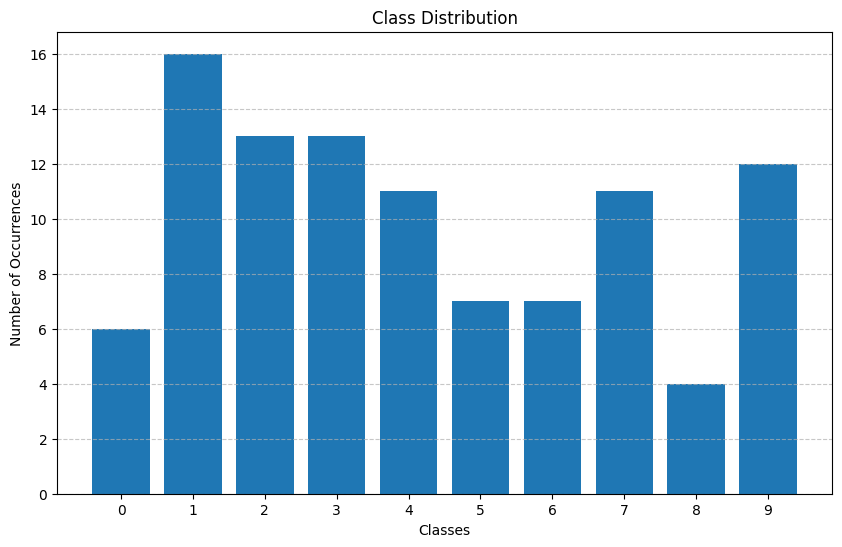

In [7]:
labels = []
for _, label in train_loader:
    labels.extend(label.tolist())

# Count occurrences of each class
class_counts = {}
for label in labels:
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1

# Plot histogram of class distribution
classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(classes, counts)
plt.xlabel('Classes')
plt.ylabel('Number of Occurrences')
plt.title('Class Distribution')
plt.xticks(np.arange(min(classes), max(classes)+1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# The Baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate scheduler (i.e. how to decrease the learning rate as a function of the number of epochs). A possible scheduler is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper (obviously, it is a different context for those researchers who had access to GPUs!) : http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. 

## ResNet architectures

__Question 3 (2 points) :__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint :* You can re-use the following code : https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

In [11]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [12]:
device = 'cuda:0' if th.cuda.is_available() else 'cpu'

In [10]:
def train(model, 
          epochs, 
          optimizer, 
          criterion, 
          data_loader, 
          device,
          plot_results=True):

    print("Starting training")

    model = model.to(device)

    loss     = np.zeros(epochs, dtype=float)
    accuracy = np.zeros(epochs, dtype=float)

    for epoch in (pbar := tqdm(range(epochs))): 

        model.train()

        epoch_loss, n_samples, n_correct = 0, 0, 0

        for _, (data, target) in enumerate(data_loader):

            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)

            tmp_loss = criterion(output, target)
            tmp_loss.backward()
            optimizer.step()

            epoch_loss += tmp_loss.item()
            predicted_batch = output.argmax(dim=1)
            n_samples += len(target) 
            n_correct += (predicted_batch == target).sum()

        accuracy[epoch] = (100 * n_correct / n_samples).item()
        loss[epoch]     = epoch_loss / len(data_loader)

        pbar.set_description('Epoch {} - Loss : {:.2f} / Accuracy : {:.2f} %'.format(epoch+1, loss[epoch], accuracy[epoch]))

    if plot_results:

        fig, ax = plt.subplots(1,2 , figsize=(15,5))

        ax[0].plot(np.arange(len(accuracy)), accuracy)
        ax[0].set_title('Accuracy')
        ax[0].set_xlabel('epoch')

        ax[1].plot(np.arange(len(loss)), loss)
        ax[1].set_title('Loss')
        ax[1].set_xlabel('epoch')

        plt.show()
    
    return accuracy

def test(model, 
          criterion, 
          data_loader,
          device
          ):

    print("Starting testing")

    model.eval()

    with th.no_grad():

        tmp_loss, n_correct, n_samples = 0, 0, 0

        for _, (data, target) in tqdm(enumerate(data_loader)):

            data, target = data.to(device), target.to(device)
            output = model(data)

            tmp_loss  += criterion(output, target).item()
            predicted_batch = output.argmax(dim=1)
            n_correct += (predicted_batch == target).sum()
            n_samples += len(target)

        loss = tmp_loss/len(data_loader)
        accuracy = 100 * n_correct / n_samples
        
        print('Test - Loss : {:.2f} / Accuracy : {:.2f} %'.format(loss, accuracy))

    return accuracy

Starting training


Epoch 20 - Loss : 0.21 / Accuracy : 94.00 %: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


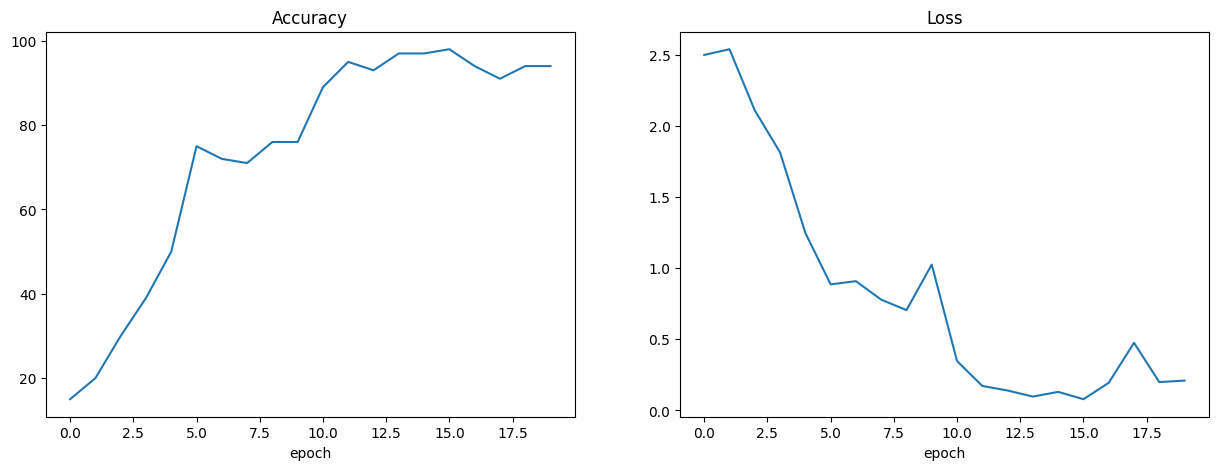

Starting testing


1000it [00:02, 357.02it/s]

Test - Loss : 5.19 / Accuracy : 19.29 %


In [11]:
epochs = 20

target    = "baseline_20"
model     = ResNet18()
criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.SGD(model.parameters(), lr=0.01, momentum=0.8)

run_train_test(target,
                model, 
                epochs, 
                optimizer, 
                criterion, 
                train_loader, 
                device)

th.cuda.empty_cache()

Starting training


Epoch 100 - Loss : 0.00 / Accuracy : 100.00 %: 100%|██████████| 100/100 [00:08<00:00, 11.33it/s]


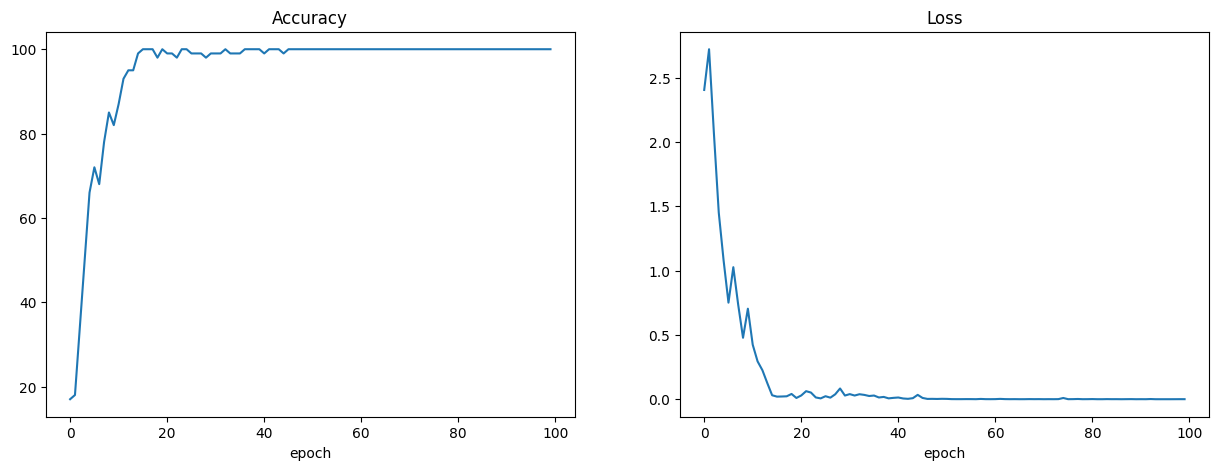

Starting testing


1000it [00:02, 357.80it/s]

Test - Loss : 3.70 / Accuracy : 23.25 %


In [12]:
epochs = 100

target    = "baseline_100"
model     = ResNet18()
criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.SGD(model.parameters(), lr=0.01, momentum=0.8)

run_train_test(target,
                model, 
                epochs, 
                optimizer, 
                criterion, 
                train_loader, 
                device)

th.cuda.empty_cache()

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   Ours  | 20 | 100% | 19.29% |
|   Ours  | 100 | 100% | 23.25% |
|   Github  | 150 | 100% | 93.02% |
|   Paper  | 750 | N/A | 94.91% |


# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on : https://pytorch.org/vision/stable/models.html.

__Question 4 (1 points):__ Pick a model from the list above, adapt it for CIFAR10 and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

In [50]:
class TransferModel(nn.Module):

    def __init__(self, target_model="resnet18", num_classes=10):
        super().__init__()

        if   target_model == "resnet18":
            self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        elif target_model == "resnet34":
            self.resnet = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        elif target_model == "resnet50":
            self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        else:
            raise NotImplementedError()

        for param in self.resnet.parameters():
            param.requires_grad = False
        
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        
        for param in self.resnet.layer4.parameters():
            param.requires_grad = True

        for param in self.resnet.fc.parameters():
            param.requires_grad = True
        
    def forward(self, x):
        return self.resnet(x)

Starting training


Epoch 100 - Loss : 0.03 / Accuracy : 99.00 %: 100%|██████████| 100/100 [00:05<00:00, 17.13it/s]


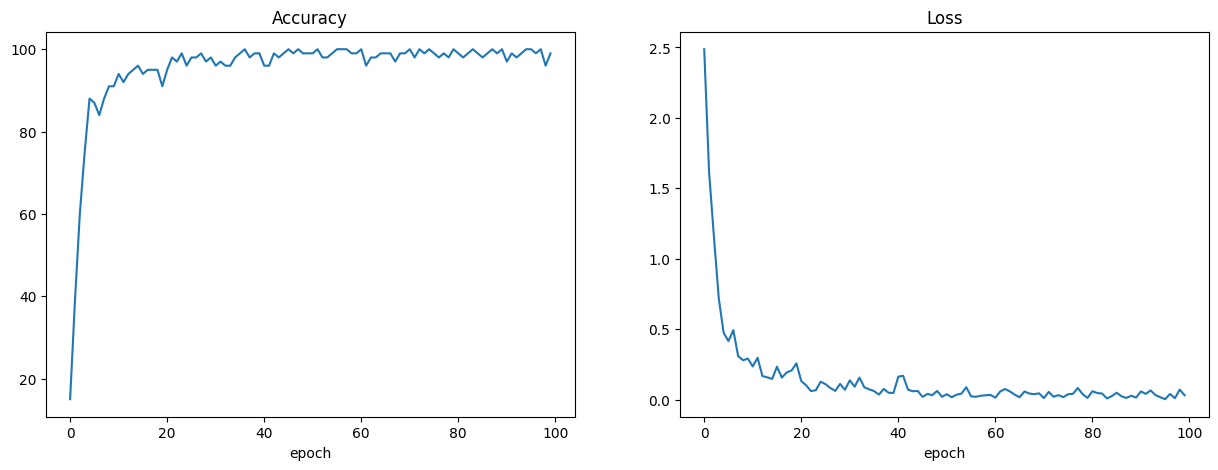

Starting testing


1000it [00:02, 366.61it/s]


Test - Loss : 3.80 / Accuracy : 27.99 %
Starting training


Epoch 100 - Loss : 0.04 / Accuracy : 99.00 %: 100%|██████████| 100/100 [00:08<00:00, 11.69it/s]


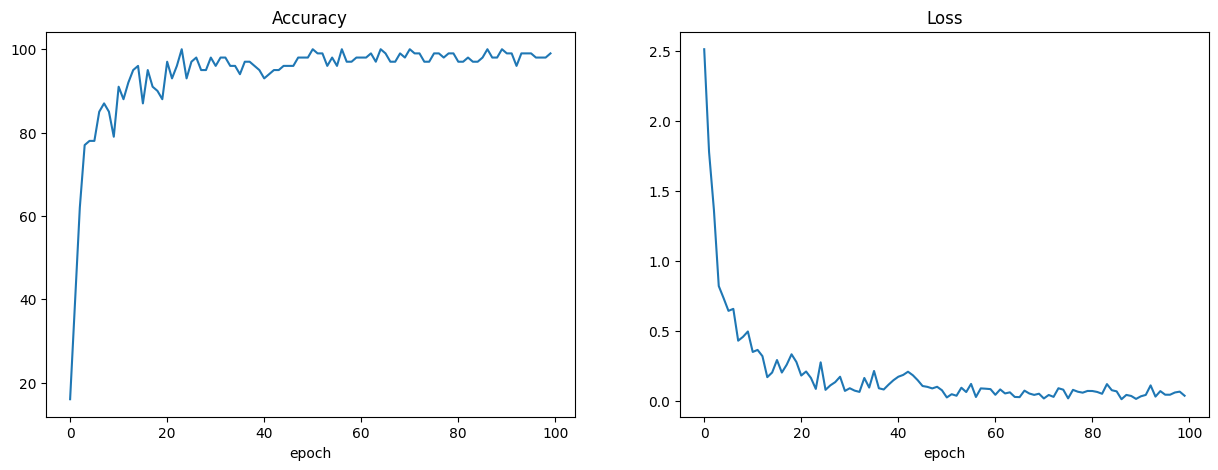

Starting testing


1000it [00:04, 241.50it/s]


Test - Loss : 3.99 / Accuracy : 25.35 %
Starting training


Epoch 100 - Loss : 0.14 / Accuracy : 98.00 %: 100%|██████████| 100/100 [00:10<00:00,  9.94it/s]


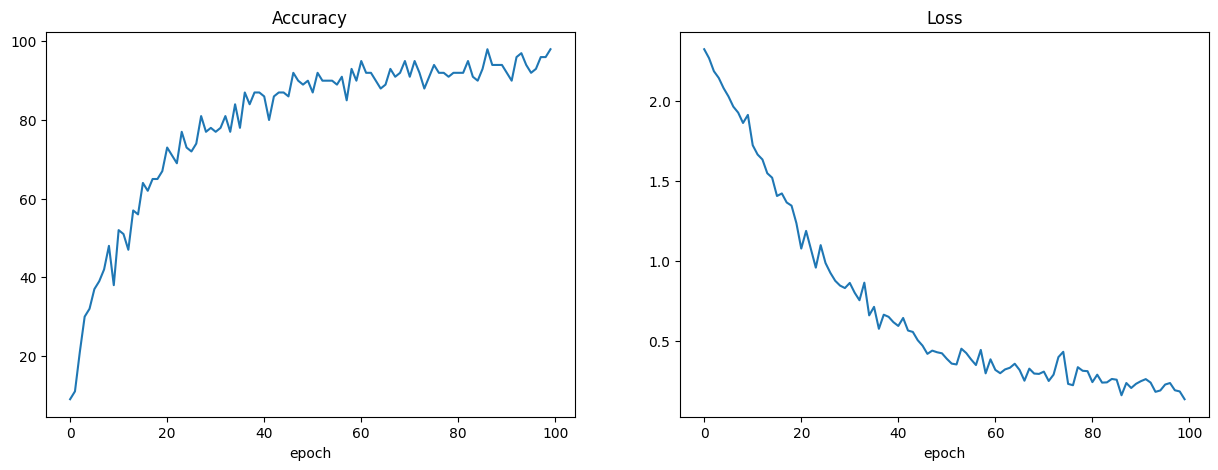

Starting testing


1000it [00:04, 200.20it/s]

Test - Loss : 8.12 / Accuracy : 25.27 %


In [14]:
epochs    = 100

target    = "resnet18"
model     = TransferModel(target)
criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

run_train_test(target,
                model, 
                epochs, 
                optimizer, 
                criterion, 
                train_loader, 
                device)

epochs    = 100
target    = "resnet34"
model     = TransferModel(target)
criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

run_train_test(target,
                model, 
                epochs, 
                optimizer, 
                criterion, 
                train_loader, 
                device)


epochs    =  100
target    = "resnet50"
model     = TransferModel(target)
criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

run_train_test(target,
                model, 
                epochs, 
                optimizer, 
                criterion, 
                train_loader, 
                device)

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18  | 100 | 100% | 27.99% |
|   ResNet34  | 100 | 100% | 25.35% |
|   ResNet50  | 100 | 100% | 25.27% |

# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks, though one might have to handle several boundary effects.

__Question 5 (0.5 points) :__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

- **Translations**: Given that transation introduces black pixels, part of the image information is lost because the pixels outside the newly translated image are not taken into account. One idea to tackle this issue would be to wrap those pixels around the edges in order to keep some of their information.

- **Rotations**: Rotations, when different than modulo $\pi$, do not fit the "image grid" perfectly, leading to significant differences from the original image, especially on very low resolution. The solution would be to use the most suitable interpolation algorithm, but it will not fix the issue completely.

- **Scaling effects**: Once again, with images with such low resolution, the scaling can lead to very distorded, and blurry image. A solution would be to apply anti-aliasing to the image after scaling it.

- **Color changes**: When color alterations are made to an RGB image, it impacts both the color and intensity data, leading to images with unrealistic colors. This is due to the fact that the channels in an RGB image often have a significant correlation. To avoid this problem, we can convert images from RGB space to another colorspace such as HSV since it separates the image intensity from the color information. 

## Data augmentations

__Question 6 (4 points):__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.

Files already downloaded and verified
Files already downloaded and verified
Starting training


Epoch 100 - Loss : 0.00 / Accuracy : 100.00 %: 100%|██████████| 100/100 [00:08<00:00, 11.11it/s]


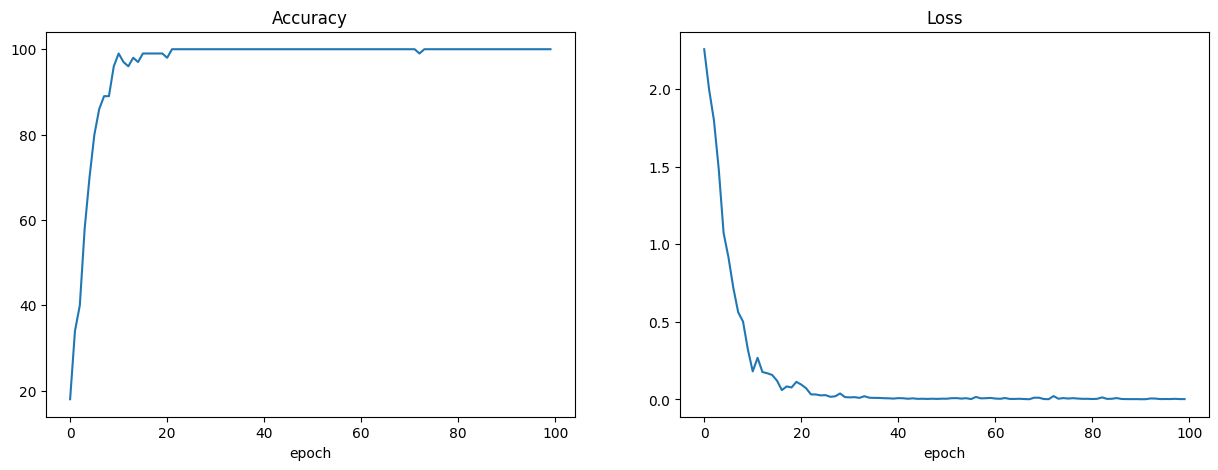

Starting testing


1000it [00:03, 324.01it/s]


Test - Loss : 3.11 / Accuracy : 24.23 %
Files already downloaded and verified
Starting training


Epoch 100 - Loss : 0.00 / Accuracy : 100.00 %: 100%|██████████| 100/100 [00:08<00:00, 11.64it/s]


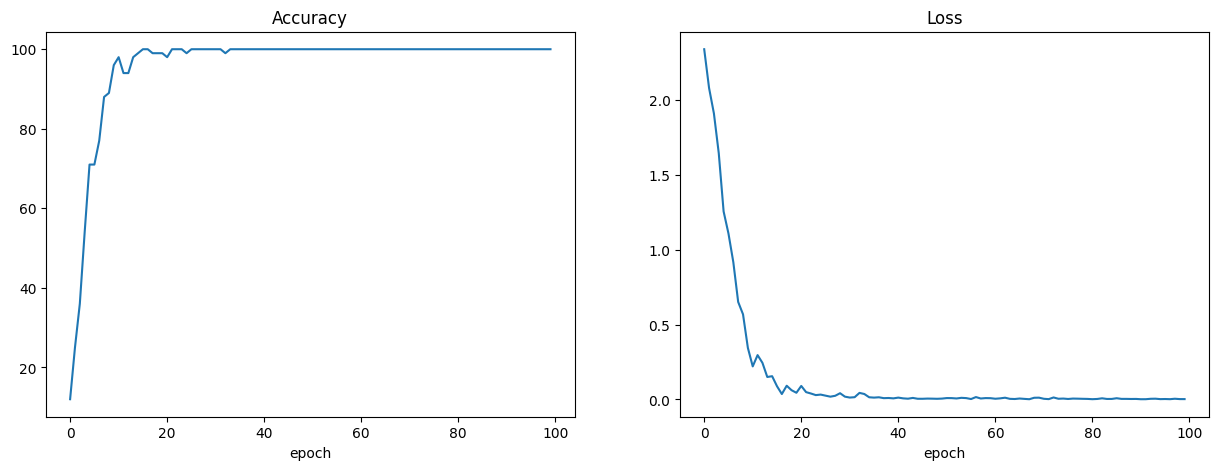

Starting testing


1000it [00:02, 375.47it/s]


Test - Loss : 3.00 / Accuracy : 22.25 %
Files already downloaded and verified
Starting training


Epoch 100 - Loss : 0.05 / Accuracy : 99.00 %: 100%|██████████| 100/100 [00:08<00:00, 11.45it/s]


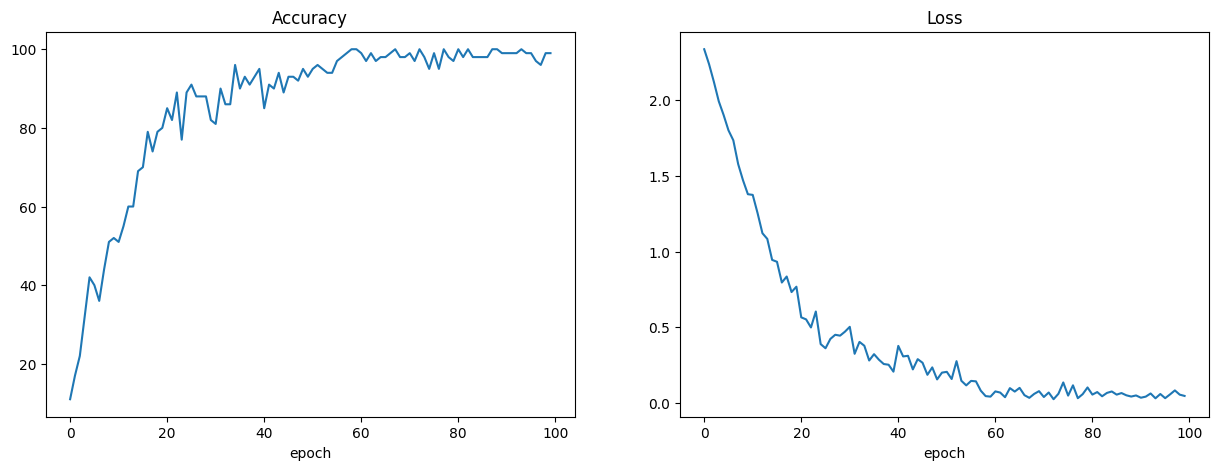

Starting testing


1000it [00:02, 341.26it/s]


Test - Loss : 4.57 / Accuracy : 23.63 %
Files already downloaded and verified
Starting training


Epoch 100 - Loss : 0.00 / Accuracy : 100.00 %: 100%|██████████| 100/100 [00:14<00:00,  7.13it/s]


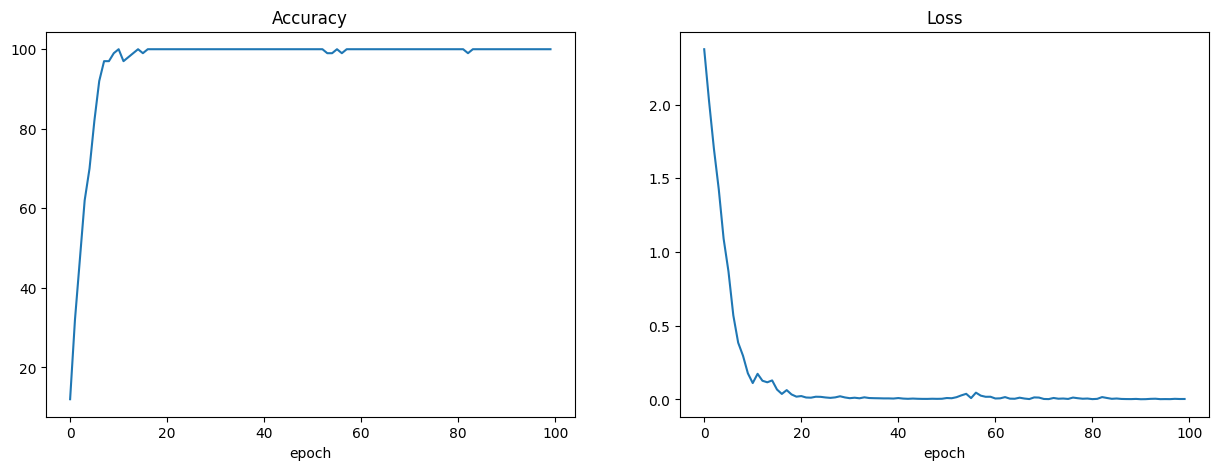

Starting testing


1000it [00:02, 379.39it/s]


Test - Loss : 2.80 / Accuracy : 23.13 %
Files already downloaded and verified
Starting training


Epoch 100 - Loss : 0.00 / Accuracy : 100.00 %: 100%|██████████| 100/100 [00:10<00:00,  9.79it/s]


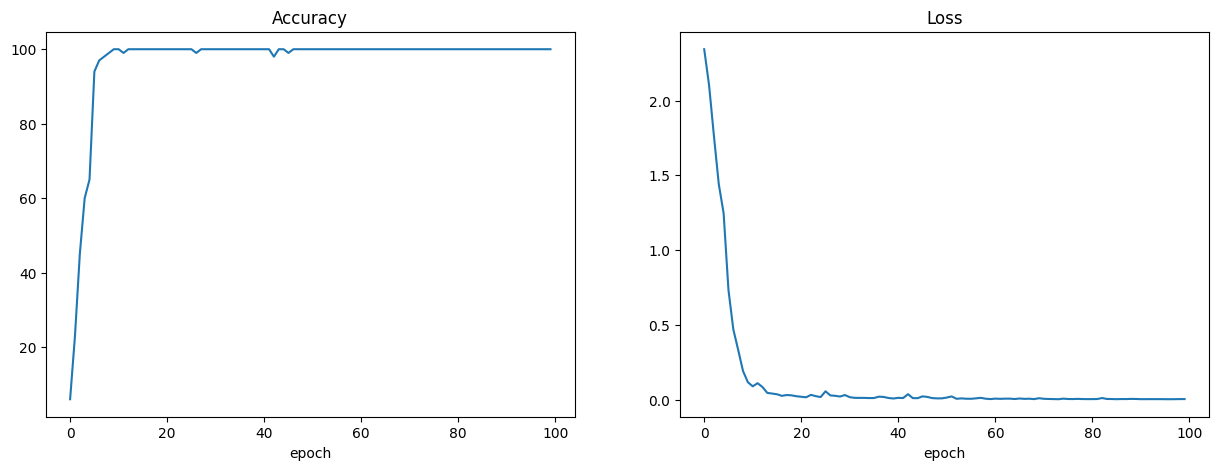

Starting testing


1000it [00:02, 363.76it/s]

Test - Loss : 2.78 / Accuracy : 24.19 %


In [15]:
batch_size = 10

transformations = [
    (transforms.RandomHorizontalFlip,   [],         {}),
    (transforms.RandomVerticalFlip,     [],         {}),
    (transforms.RandomCrop,             [30],       {"padding":4}),
    (transforms.GaussianBlur,           [],         {"kernel_size": (3,3)}),
    (transforms.ColorJitter,            [],         {"hue":.1})
]

base_transforms = [
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
]

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

testset      = torchvision.datasets.CIFAR10(root ="\content", train=False, download=True, transform=test_transform)
test_loader  = th.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

for transform, args, kwargs in transformations:

    train_tranforms = transforms.Compose([
        transform(*args, **kwargs),
        *base_transforms
    ])

    trainset     = torchvision.datasets.CIFAR10(root ="\content", train=True, download=True, transform=train_tranforms)
    train_loader = th.utils.data.DataLoader(th.utils.data.Subset(trainset, list(np.arange(100))), 
                                            batch_size=batch_size, 
                                            shuffle=True)

    epochs    = 100

    target    = "data_augmentation" + "_" + transform.__name__
    model     = ResNet18()
    criterion = th.nn.CrossEntropyLoss()
    optimizer = th.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    run_train_test(target,
                    model, 
                    epochs, 
                    optimizer, 
                    criterion, 
                    train_loader, 
                    device)

Files already downloaded and verified
Files already downloaded and verified
Starting training


Epoch 100 - Loss : 0.00 / Accuracy : 100.00 %: 100%|██████████| 100/100 [00:10<00:00,  9.44it/s]


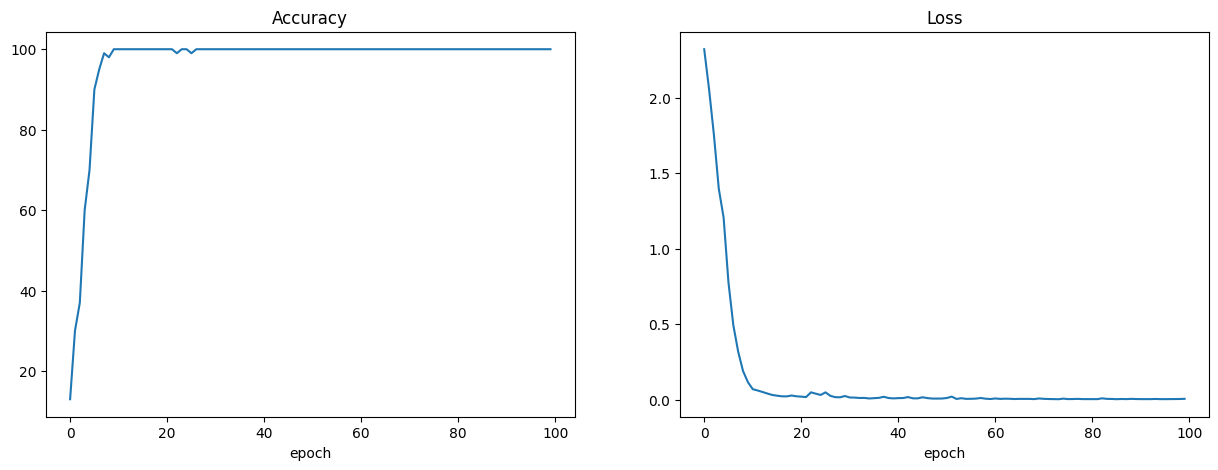

Starting testing


1000it [00:02, 353.49it/s]

Test - Loss : 2.91 / Accuracy : 23.51 %


In [16]:
epochs    = 100

target    = "data_augmentation_all"
model     = ResNet18()
criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomCrop(30, padding=4),
    transforms.GaussianBlur(kernel_size=(3,3)),
    transforms.ColorJitter(hue=.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset     = torchvision.datasets.CIFAR10(root ="\content", train=True, download=True, transform=train_tranforms)
train_loader = th.utils.data.DataLoader(th.utils.data.Subset(trainset, list(np.arange(100))), 
                                        batch_size=batch_size, 
                                        shuffle=True)

testset      = torchvision.datasets.CIFAR10(root ="\content", train=False, download=True, transform=test_transform)
test_loader  = th.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

run_train_test(target,
                model, 
                epochs, 
                optimizer, 
                criterion, 
                train_loader, 
                device)

th.cuda.empty_cache()

Files already downloaded and verified
Files already downloaded and verified
Starting training


Epoch 100 - Loss : 0.03 / Accuracy : 100.00 %: 100%|██████████| 100/100 [00:07<00:00, 12.73it/s]


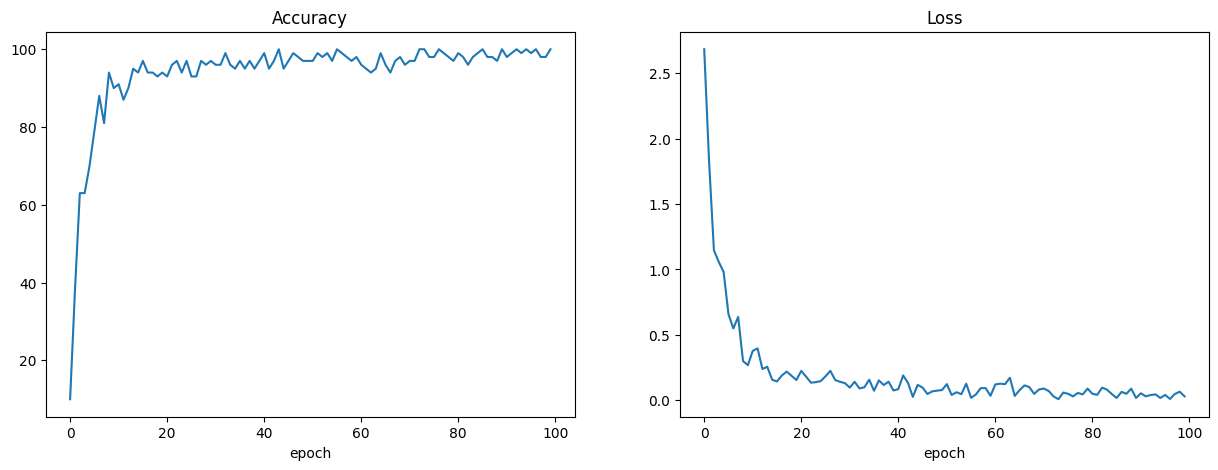

Starting testing


1000it [00:02, 345.48it/s]

Test - Loss : 3.86 / Accuracy : 28.74 %


In [17]:
epochs    = 100

target    = "data_augmentation_RandomHorizontalFlip_transfer"
model     = TransferModel("resnet18")
criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset     = torchvision.datasets.CIFAR10(root ="\content", train=True, download=True, transform=train_tranforms)
train_loader = th.utils.data.DataLoader(th.utils.data.Subset(trainset, list(np.arange(100))), 
                                        batch_size=batch_size, 
                                        shuffle=True)

testset      = torchvision.datasets.CIFAR10(root ="\content", train=False, download=True, transform=test_transform)
test_loader  = th.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

run_train_test(target,
                model, 
                epochs, 
                optimizer, 
                criterion, 
                train_loader, 
                device)

th.cuda.empty_cache()

Files already downloaded and verified
Files already downloaded and verified
Starting training


Epoch 100 - Loss : 0.03 / Accuracy : 100.00 %: 100%|██████████| 100/100 [00:07<00:00, 12.65it/s]


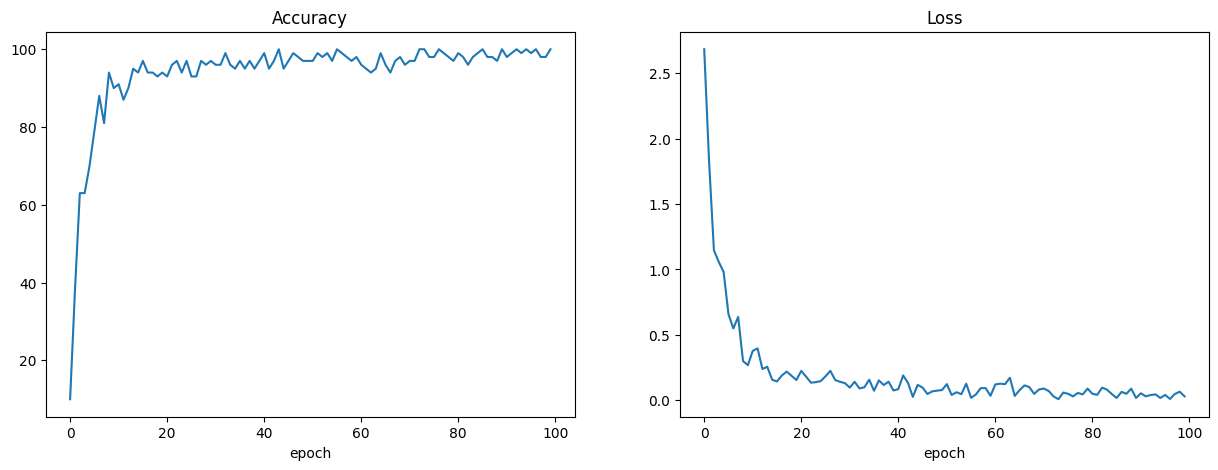

Starting testing


1000it [00:02, 353.10it/s]

Test - Loss : 3.86 / Accuracy : 28.74 %


In [18]:
epochs    = 100

target    = "data_augmentation_all_transfer"
model     = TransferModel("resnet18")
criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomCrop(30, padding=4),
    transforms.GaussianBlur(kernel_size=(3,3)),
    transforms.ColorJitter(hue=.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset     = torchvision.datasets.CIFAR10(root ="\content", train=True, download=True, transform=train_tranforms)
train_loader = th.utils.data.DataLoader(th.utils.data.Subset(trainset, list(np.arange(100))), 
                                        batch_size=batch_size, 
                                        shuffle=True)

testset      = torchvision.datasets.CIFAR10(root ="\content", train=False, download=True, transform=test_transform)
test_loader  = th.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

run_train_test(target,
                model, 
                epochs, 
                optimizer, 
                criterion, 
                train_loader, 
                device)

th.cuda.empty_cache()

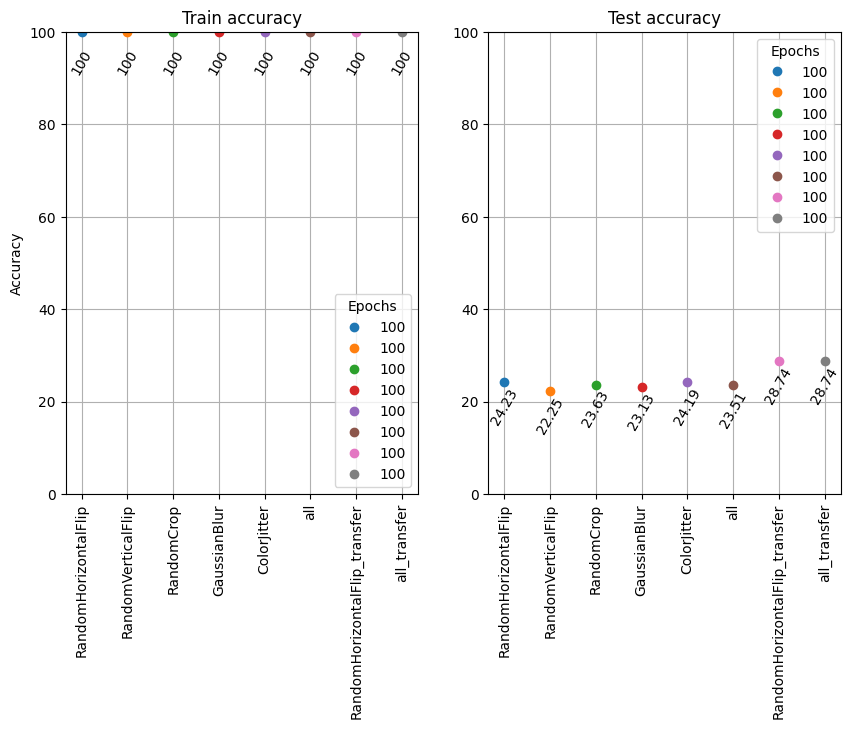

In [19]:
plot_results(filter="data_augmentation_")

| Model | Transform | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|------|
|   ResNet18  |   RandomHorizontalFlip  | 100 | 100% | 24.23% |
|   ResNet18  |   RandomVerticalFlip    | 100 | 100% | 22.25% |
|   ResNet18  |   RandomCrop            | 100 | 100% | 23.63% |
|   ResNet18  |   GaussianBlur          | 100 | 100% | 23.13% |
|   ResNet18  |   ColorJitter           | 100 | 100% | 24.19% |
|   ResNet18  |   All                   | 100 | 100% | 23.51% |
|   ResNet18 (Pretrained)  |   RandomHorizontalFlip                   | 100 | 100% | 28.74% |
|   ResNet18 (Pretrained) |   All                   | 100 | 100% | 28.74% |

# Conclusions

__Question 7 (3 points) :__ Write a short report explaining the pros and the cons of each method that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

During this practical assignement, we evaluated different training strategies to tackle the issue of a small dataset. 

**Baseline**

We implemented a baseline ResNet18 to establish a foundation for comparison with other methods. This baseline model yielded poor performance on the test set with 20 epochs (19.29%) explainable by the extremely low amount of training data, leading to an overfit of the model. Increasing the number of epochs to 100 did improve the test accuracy to 23.25%, so we decided to keep this as the baseline.

**Transfer learning**

The first method explored to improve these results was to use transfer learning. We used 3 resnet models, namely resnet18, resnet34 and resnet50 with pretrained weigths. By unfreezing the last two layers (the layer 4 as well as the fully connected layer) and freezing the rest of the model, we were able to improve greatly the test accuracy, reaching 27.99% for ResNet18. The pretrained was able to generalise better thanks to the pretaining. The bigger models, while getting better results than the baseline, yielded lower improvements (25.35% and 25.27%) while converging at a slower pace. We can conclude that using a more complicated architecture does not necessarly improve the results, especially in case of low amount of data, which was to be expected.

**Data Augmentation**

The second method explored is data augmentation. We first tested the improvements made for each method alone on the baseline model with 100 epochs. The tested methods were, Random Horizontal Cropping, Random vertical cropping, Gaussian Blur, and Color Jitter. Each method alone did not improve the performance of the model, appart from the randomHorizontalFlip that allowed the model to reach a 24.23% accuracy. This improvement is very small and may seem within the margin of error, but when running on multiple seeds, this transformation always lead to better performance than the others. Using all the proposed augmentations together (RandomHorizontalFlip, RandomVerticalFlip, RandomCropping, GaussianBlur, ColorJitter) did not always improve the results by a lot. For the current seed, there seem to be not improvement. A better crafted data augmentation may lead to better results, but we did not manage to find the right ones. It is to be noted that applying the wrong transformations leads to terrible results. 

The best results were obtained by using both the data transformations and the transfer learning, allowing us to achieve an accuracy of 28.74% more than a 5% increase over the baseline performance.

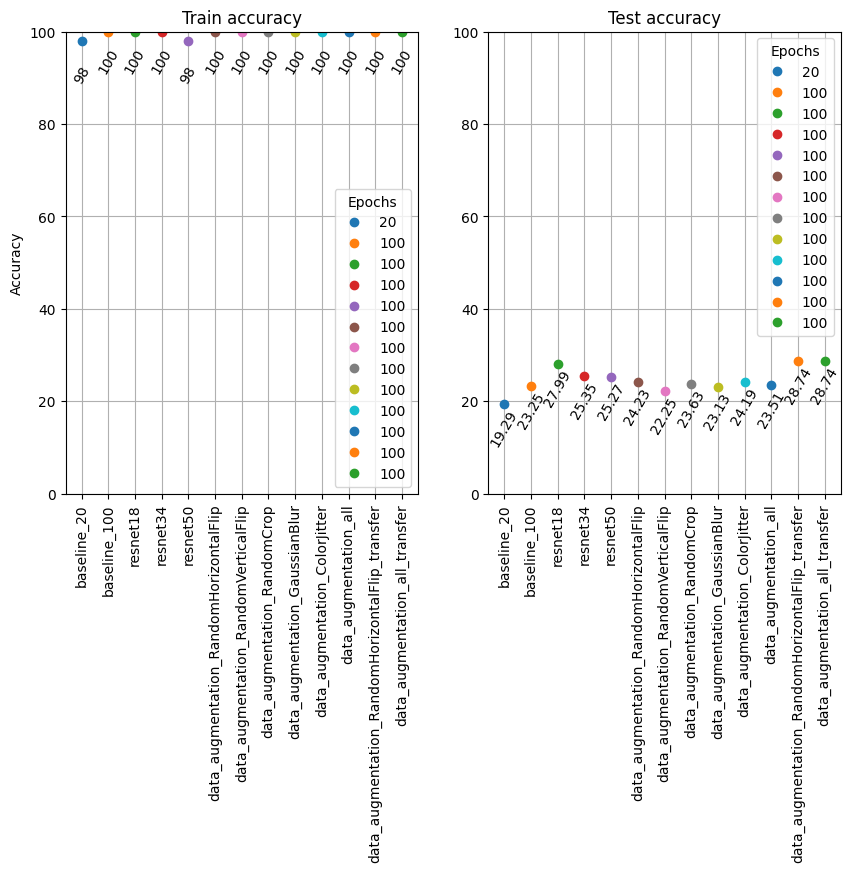

In [20]:
plot_results()

# Weak supervision

__Bonus \[open\] question (up to 3 points) :__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.


### Pseudo Label

The first method explore is the Pseudo Label Method (***Pseudo-Label: The Simple and Efficient Semi-Supervised Learning Method for Deep Neural Networks, Lee Dong-Hyun***). The idea is to first train the model on the available labeled data before using the unlabeled data. We use the model's own predictions as "pseudo labels" for the unlabeled data. However, only the predictions with high confidence (above a predefined threshold) are used as labels. This selective approach helps to mitigate the risk of reinforcing incorrect predictions. The process iterates with the network being trained on both the original labeled data and the newly labeled (via pseudo labels) unlabeled data.

We did not manage to get this method to work. Despite our efforts we did not achieve improved accuracy, our best accuracy with this method being 18.73%.

In [45]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 20

trainset      = torchvision.datasets.CIFAR10(root ="\content", train=True, download=True, transform=transform)
labeled_set   = th.utils.data.Subset(trainset, range(100)) 
unlabeled_set = th.utils.data.Subset(trainset, range(100, 1000))

labeled_loader = th.utils.data.DataLoader(labeled_set, 
                                        batch_size=batch_size, 
                                        shuffle=True)

unlabeled_loader = th.utils.data.DataLoader(unlabeled_set, 
                                        batch_size=100, 
                                        shuffle=True)

testset      = torchvision.datasets.CIFAR10(root ="\content", train=False, download=True, transform=transform)
test_loader  = th.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def compute_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with th.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = th.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [27]:
reset_seed()

model     = ResNet18()
criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model.to(device)

threshold = 0.9

epochs = 100

training_accuracy = np.zeros(epochs, dtype=float)

for epoch in (pbar := tqdm(range(epochs))):
    model.train()
    total_loss = 0
    for (labeled_images, labels) in labeled_loader:
        labeled_images, labels = labeled_images.to(device), labels.to(device)
        outputs = model(labeled_images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()


    for unlabeled_images, _ in unlabeled_loader:
        model.eval()
        unlabeled_images = unlabeled_images.to(device)
        outputs = model(unlabeled_images)
        probs, pseudo_labels = th.max(F.softmax(outputs, dim=1), dim=1)
        mask = probs > threshold 

        if mask.sum() > 0:
            model.train() 
            unlabeled_images_masked = unlabeled_images[mask].to(device)
            optimizer.zero_grad()
            outputs = model(unlabeled_images_masked)
            pseudo_labels_masked = pseudo_labels[mask].detach() 
            loss = criterion(outputs, pseudo_labels_masked)
            loss.backward()
            optimizer.step()
    
    training_accuracy[epoch] = compute_accuracy(model, labeled_loader)


    if (epoch + 1) % 50 == 0:  
        pbar.set_description("Computing Test accuracy")
        test_accuracy = compute_accuracy(model, test_loader)
        
    pbar.set_description(' Train Acc : {:.2f} / Test Acc : {:.2f} %'.format(training_accuracy[epoch], test_accuracy))


th.cuda.empty_cache()

 Train Acc : 100.00 / Test Acc : 17.15 %: 100%|██████████| 100/100 [00:23<00:00,  4.18it/s]


### Mean Teachers

The second method explored is Mean teachers (***Mean Teachers are Better Role Models: Weight-Averaged Consistency Targets Improve Semi-Supervised Deep Learning Results*** ). This method uses two models: a student and a teacher model. Both are identical in structure but differ in parameters. During training, both models receive input data; however, the teacher model's weights are an exponential moving average of the student's. The student is trained using labeled data and a consistency loss that aligns its outputs with the teacher's on unlabeled data. This process encourages the student to produce stable outputs similar to the teacher's, improving its generalization on unlabeled data.

In [53]:
def update_teacher_model(student_model, teacher_model, alpha=0.5):
    for teacher_params, student_params in zip(teacher_model.parameters(), student_model.parameters()):
        teacher_params.data.mul_(alpha).add_(1 - alpha, student_params.data)

In [54]:
reset_seed()

epochs = 1000

lambda_consistency = 4

training_accuracy = np.zeros(epochs, dtype=float)

student_model = ResNet18().to(device)
teacher_model = copy.deepcopy(student_model)
teacher_model.eval()

optimizer = th.optim.SGD(student_model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
consistency_loss = nn.MSELoss() 

for epoch in (pbar := tqdm(range(epochs))):
    student_model.train()
    for (inputs, labels), (unlabeled_inputs, _) in zip(labeled_loader, unlabeled_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        unlabeled_inputs = unlabeled_inputs.to(device)

        student_outputs = student_model(inputs)
        loss = criterion(student_outputs, labels)
        
        with th.no_grad():
            teacher_outputs = teacher_model(unlabeled_inputs)
        student_outputs_unlabeled = student_model(unlabeled_inputs)
        
        cons_loss = consistency_loss(student_outputs_unlabeled, teacher_outputs.detach())
        total_loss = loss + lambda_consistency * cons_loss 

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        update_teacher_model(student_model, teacher_model)

    training_accuracy[epoch] = compute_accuracy(model, labeled_loader)

    if (epoch + 1) % 100 == 0:  
        pbar.set_description("Computing Test accuracy")
        test_accuracy = compute_accuracy(student_model, test_loader)
        
    pbar.set_description(' Train Acc : {:.2f} / Test Acc : {:.2f} %'.format(training_accuracy[epoch], test_accuracy))

th.cuda.empty_cache()


 Train Acc : 100.00 / Test Acc : 18.49 %: 100%|██████████| 1000/1000 [04:33<00:00,  3.66it/s]
